In [11]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

In [12]:
class FunctionMinimizationEnv(gym.Env):
    def __init__(self, max_step=100, patience=10):
        super().__init__()
        self.param_dim = 1  # Example: 1 parameter
        self.action_space_limit = [-1, 1]
        self.action_space = spaces.Box(
            low=self.action_space_limit[0],
            high=self.action_space_limit[1],
            shape=(self.param_dim,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.param_dim,), dtype=np.float32
        )
        self.state = np.zeros(self.param_dim, dtype=np.float32)
        self.count = 0
        self.global_value = float("inf")
        self.max_step = max_step
        self.patience = patience
        self.patience_remaining = patience

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.random.uniform(-10, 10, size=(self.param_dim,))
        # self.state = np.array([10], dtype=np.float32)  # Fixed start
        self.count = 0
        self.global_value = self.target_function(self.state)
        self.patience_remaining = self.patience
        # Gymnasium reset returns (obs, info)
        return self.state, {}

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, self.action_space_limit[0], self.action_space_limit[1])
        self.state = self.state + action
        value = self.target_function(self.state)
        # reward = self.global_value - value  # Positive reward for improvement
        
        # epsilon = 1e-6  # Prevent division by zero
        # alpha = 1.0  # Tune as needed
        # improvement = self.global_value - value
        # reward = improvement + alpha * (1 / (np.abs(value) + epsilon))
        
        target_solution = 0.5  # Known minimum
        d = np.maximum(value - target_solution, 0.0)
        c = 0.5  # Scale parameter
        p = 2    # Shape parameter
        reward = 1 / (1 + np.power((d / c), p))


        if reward > 0:  # Improvement found
            self.global_value = value  # Update global best
            self.patience_remaining = self.patience  # Reset patience
        else:  # No improvement
            self.patience_remaining -= 1

        self.count += 1
        if self.patience_remaining <= 0 or self.count >= self.max_step:
            terminated = True
        else:
            terminated = False
            
        truncated = False
        info = {
            "action": action,
            "state": self.state,
            "value": value,
            "global_value": self.global_value,
            "reward": reward,
            "steps": self.count,
            "patience_remaining": self.patience_remaining,
        }
        # Gymnasium step returns (obs, reward, terminated, truncated, info)
        return self.state, reward, terminated, truncated, info

    def target_function(self, x):
        return np.sum(x**2)  # Example: minimize sum of squares

In [13]:
from stable_baselines3 import SAC

env = FunctionMinimizationEnv(patience=20, max_step=50)
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 2.75     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 156      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -1.13    |
|    critic_loss     | 0.0658   |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.0501  |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 2.67     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 114      |
|    time_elapsed    | 3        |
|    total_timesteps | 400      |
| train/             |

,action,state,value,global_value,reward,steps,patience_remaining
0,[0.22884512],[-4.173252758795977],17.416039,17.416039,0.000873,1,20
1,[0.24138784],[-3.9318649147102835],15.459562,15.459562,0.001116,2,20
2,[0.2637565],[-3.6681084011147025],13.455019,13.455019,0.001487,3,20
3,[0.3057196],[-3.362388787085772],11.305658,11.305658,0.002137,4,20
4,[0.3581524],[-3.0042363975594046],9.025436,9.025436,0.003428,5,20
5,[0.42212975],[-2.5821066473076346],6.667275,6.667275,0.006530,6,20
6,[0.4968511],[-2.0852555606911185],4.348291,4.348291,0.016601,7,20
7,[0.5790248],[-1.5062307689735892],2.268731,2.268731,0.073999,8,20
8,[0.6256362],[-0.8805945489952567],0.775447,0.775447,0.767175,9,20
9,[0.566375],[-0.314219531829119],0.098734,0.098734,1.000000,10,20


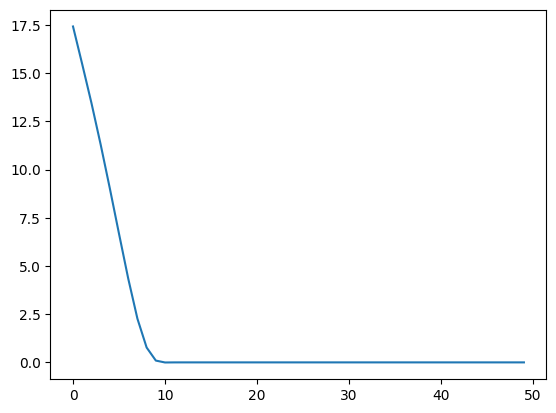

In [14]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data.append(info)

df = pd.DataFrame.from_dict(data)
df.global_value.plot()
# display(df.iloc[[0, -1], :])
display(df)

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(
    model,
    env,
    n_eval_episodes=100,  # Number of episodes to run for evaluation
    deterministic=True,  # Use deterministic actions for evaluation
    render=False,  # Set to True if you want to visualize the agent
)

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 27.14 +/- 17.06
